In [1]:
# Checa GPUs disponiveis
import tensorflow as tf
print("Numero de GPUs disponiveis: ", len(tf.config.list_physical_devices('GPU')))

Numero de GPUs disponiveis:  1


In [2]:
# imports para treino e previsao
import cv2

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope

from woundSegmentation.models.unets import Unet2D
from woundSegmentation.models.deeplab import Deeplabv3, relu6, DepthwiseConv2D, BilinearUpsampling
from woundSegmentation.models.FCN import FCN_Vgg16_16s, VGG_19
from woundSegmentation.models.SegNet import SegNet

from woundSegmentation.utils.BilinearUpSampling import BilinearUpSampling2D
from woundSegmentation.utils.learning.metrics import dice_coef, precision, recall
from woundSegmentation.utils.learning.losses import dice_coef_loss
from woundSegmentation.utils.io.data import DataGen, save_results, save_history, load_data, save_rgb_results, load_test_images

import tensorflow as tf

import os
import time

<h3>Configuração inicial de diretorios</h3>

In [3]:
# Modelos disponiveis
models = ["fcn", "mobilenetv2", "segnet", "unet"]

In [4]:
# Criacao de arquivos
dirPath = 'woundSegmentation/results/'
isdir = os.path.isdir(dirPath)
if not isdir:
    os.mkdir('woundSegmentation/results/')
    for i in range(len(models)):
        os.mkdir(dirPath + models[i])
        os.mkdir(dirPath + models[i] + "/training_history/")
        os.mkdir(dirPath + models[i] + "/datapredict/")

<h3>ESCOLHA DO MODELO</h3>

In [5]:
# Insira o modelo desejado
modelName = "fcn"
modelDirPath = dirPath + modelName + "/"

In [6]:
# Variaveis e gerador de dados
input_dim_x = 224
input_dim_y = 224
n_filters = 32
dataset = 'Foot Ulcer Segmentation Challenge'
datasetpath = 'woundSegmentation/data/' + dataset
#dataset= 'Medetec_foot_ulcer_224'
data_gen = DataGen('woundSegmentation/data/' + dataset + '/', split_ratio=0.2, x=input_dim_x, y=input_dim_y)

In [7]:
# Unet
if (modelName == "unet"):
    unet2d = Unet2D(n_filters=n_filters, input_dim_x=None, input_dim_y=None, num_channels=3)
    model, model_name = unet2d.get_unet_model_yuanqing()
    print("Modelo Unet Carregado!")

In [8]:
# SegNet
if (modelName == "segnet"):
    segNet = SegNet(n_filters=n_filters, input_dim_x=None, input_dim_y=None, num_channels=3)
    model, model_name = segNet.get_SegNet()
    print("Modelo Segnet Carregado!")

In [9]:
# MobilenetV2
if (modelName == "mobilenetv2"):
    model = Deeplabv3(input_shape=(input_dim_x, input_dim_y, 3), classes=1)
    model_name = 'MobilenetV2'
    print("Modelo MobilenetV2 Carregado!")

In [10]:
# FCN
if (modelName == "fcn"):
    model = VGG_19(input_shape=(input_dim_x, input_dim_y, 3))
    model_name = 'FCN'
    print("Modelo FCN Carregado!")

Modelo FCN Carregado!


In [11]:
# Cria o txt do resumo do modelo
def printmodelsummary(s):
    with open(modelDirPath + modelName + 'Modelsummary.txt','a') as f:
        print(s, file=f)

model.summary(print_fn=printmodelsummary)

In [12]:
# Modelo pre treinado
#with CustomObjectScope({'relu6': relu6,'DepthwiseConv2D': DepthwiseConv2D, 'BilinearUpsampling': BilinearUpsampling}):
#    model = load_model('woundSegmentation/training_history/2019-12-19 01%3A53%3A15.480800.hdf5'
#                       , custom_objects={'dice_coef': dice_coef, 'precision':precision, 'recall':recall})

<h3>Treinamento</h3>

In [13]:
# Configuracoes de treinamento
batch_size = 2
epochs = 240
learning_rate = 1e-4
loss = 'binary_crossentropy'

In [14]:
# Paciencia para early stoping
callbacks = [
        EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', restore_best_weights=True)
    ]

In [15]:
# Treinamento
start = time.time()
model.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=[dice_coef, precision, recall])
training_history = model.fit_generator(data_gen.generate_data(batch_size=batch_size, train=True),
                                       steps_per_epoch=int(data_gen.get_num_data_points(train=True) / batch_size),
                                       callbacks=callbacks,
                                       validation_data=data_gen.generate_data(batch_size=batch_size, val=True),
                                       validation_steps=int(data_gen.get_num_data_points(val=True) / batch_size),
                                       epochs=epochs)
end = time.time()
file = open(modelDirPath + modelName +"Time.txt", "w")
file.write("Treinamento\n")
file.write(str(end-start))
file.close()

Epoch 1/240


C:\Users\rafa_\miniconda3\envs\gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\rafa_\AppData\Local\Temp\ipykernel_21172\1540222364.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history = model.fit_generator(data_gen.generate_data(batch_size=batch_size, train=True),


324/324 [==============================] - 22s 53ms/step - loss: 0.4591 - dice_coef: 0.2729 - precision: 0.2025 - recall: 0.7305 - val_loss: 0.3750 - val_dice_coef: 0.3604 - val_precision: 0.5020 - val_recall: 0.3278
Epoch 2/240
324/324 [==============================] - 17s 52ms/step - loss: 0.3064 - dice_coef: 0.5544 - precision: 0.5407 - recall: 0.6700 - val_loss: 0.3032 - val_dice_coef: 0.4586 - val_precision: 0.8051 - val_recall: 0.3782
Epoch 3/240
324/324 [==============================] - 17s 52ms/step - loss: 0.2502 - dice_coef: 0.6351 - precision: 0.6659 - recall: 0.7026 - val_loss: 0.2183 - val_dice_coef: 0.3404 - val_precision: 0.7839 - val_recall: 0.2545
Epoch 4/240
324/324 [==============================] - 17s 52ms/step - loss: 0.2104 - dice_coef: 0.6781 - precision: 0.7106 - recall: 0.7380 - val_loss: 0.1816 - val_dice_coef: 0.3713 - val_precision: 0.8318 - val_recall: 0.2772
Epoch 5/240
324/324 [==============================] - 17s 52ms/step - loss: 0.1773 - dice_coef:

Epoch 37/240
324/324 [==============================] - 17s 51ms/step - loss: 0.0031 - dice_coef: 0.9393 - precision: 0.9544 - recall: 0.9320 - val_loss: 0.0106 - val_dice_coef: 0.8597 - val_precision: 0.8836 - val_recall: 0.8654
Epoch 38/240
324/324 [==============================] - 17s 51ms/step - loss: 0.0028 - dice_coef: 0.9440 - precision: 0.9575 - recall: 0.9369 - val_loss: 0.0110 - val_dice_coef: 0.8574 - val_precision: 0.8986 - val_recall: 0.8480
Epoch 39/240
324/324 [==============================] - 17s 51ms/step - loss: 0.0027 - dice_coef: 0.9454 - precision: 0.9594 - recall: 0.9386 - val_loss: 0.0138 - val_dice_coef: 0.8153 - val_precision: 0.9313 - val_recall: 0.7672
Epoch 40/240
324/324 [==============================] - 17s 51ms/step - loss: 0.0027 - dice_coef: 0.9466 - precision: 0.9564 - recall: 0.9377 - val_loss: 0.0120 - val_dice_coef: 0.8377 - val_precision: 0.9220 - val_recall: 0.7987
Epoch 41/240
324/324 [==============================] - 17s 51ms/step - loss: 0.

Epoch 73/240
324/324 [==============================] - 16s 51ms/step - loss: 0.0015 - dice_coef: 0.9652 - precision: 0.9760 - recall: 0.9567 - val_loss: 0.0130 - val_dice_coef: 0.8616 - val_precision: 0.8785 - val_recall: 0.8742
Epoch 74/240
324/324 [==============================] - 17s 51ms/step - loss: 0.0015 - dice_coef: 0.9652 - precision: 0.9765 - recall: 0.9562 - val_loss: 0.0139 - val_dice_coef: 0.8554 - val_precision: 0.8888 - val_recall: 0.8555
Epoch 75/240
324/324 [==============================] - 16s 51ms/step - loss: 0.0015 - dice_coef: 0.9635 - precision: 0.9737 - recall: 0.9553 - val_loss: 0.0127 - val_dice_coef: 0.8617 - val_precision: 0.8701 - val_recall: 0.8812
Epoch 76/240
324/324 [==============================] - 17s 51ms/step - loss: 0.0016 - dice_coef: 0.9624 - precision: 0.9728 - recall: 0.9542 - val_loss: 0.0130 - val_dice_coef: 0.8503 - val_precision: 0.8997 - val_recall: 0.8404
Epoch 77/240
324/324 [==============================] - 17s 51ms/step - loss: 0.

324/324 [==============================] - 17s 52ms/step - loss: 0.0013 - dice_coef: 0.9686 - precision: 0.9788 - recall: 0.9618 - val_loss: 0.0139 - val_dice_coef: 0.8430 - val_precision: 0.8775 - val_recall: 0.8379
Epoch 109/240
324/324 [==============================] - 16s 51ms/step - loss: 0.0014 - dice_coef: 0.9660 - precision: 0.9773 - recall: 0.9582 - val_loss: 0.0135 - val_dice_coef: 0.8541 - val_precision: 0.8714 - val_recall: 0.8705
Epoch 110/240
324/324 [==============================] - 16s 51ms/step - loss: 0.0015 - dice_coef: 0.9644 - precision: 0.9753 - recall: 0.9569 - val_loss: 0.0141 - val_dice_coef: 0.8584 - val_precision: 0.8460 - val_recall: 0.8982
Epoch 111/240
324/324 [==============================] - 16s 50ms/step - loss: 0.0015 - dice_coef: 0.9636 - precision: 0.9758 - recall: 0.9555 - val_loss: 0.0142 - val_dice_coef: 0.8589 - val_precision: 0.8675 - val_recall: 0.8759
Epoch 112/240
324/324 [==============================] - 16s 50ms/step - loss: 0.0015 - di

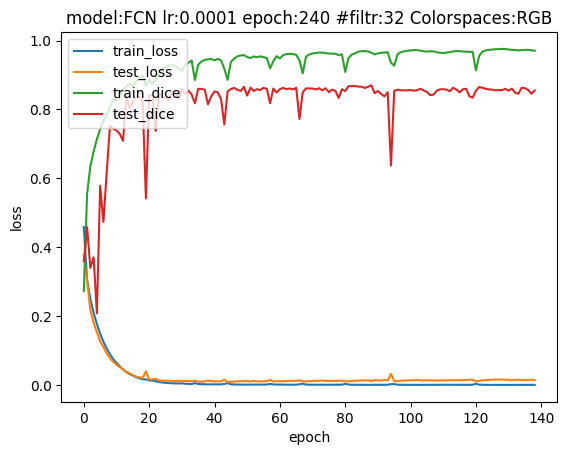

<Figure size 640x480 with 0 Axes>

In [16]:
# Salva o modelo e o historico de treinamento TROCA O NOME
save_history(model, model_name, training_history, dataset, n_filters, epochs, learning_rate, loss, color_space='RGB',
             path= modelDirPath + "training_history/", name= modelName + "modelfile")

<h3>Predicao</h3>

In [17]:
# Configuracao
color_space = 'rgb'
weight_file_name = modelName + 'modelfile.hdf5'
pred_save_path = modelDirPath + 'datapredict/'
path = 'woundSegmentation/data/' + dataset + '/'
data_gen = DataGen(path, split_ratio=0.0, x=input_dim_x, y=input_dim_y, color_space=color_space)
x_test, test_label_filenames_list = load_test_images(path)

In [18]:
model = load_model(modelDirPath + 'training_history/' + weight_file_name
               , custom_objects={'recall':recall,
                                 'precision':precision,
                                 'dice_coef': dice_coef,
                                 'relu6':relu6,
                                 'DepthwiseConv2D':DepthwiseConv2D,
                                 'BilinearUpsampling':BilinearUpsampling})

In [19]:
start = time.time()
for image_batch, label_batch in data_gen.generate_data(batch_size=len(x_test), test = True):
    prediction = model.predict(image_batch, verbose=1)
    save_results(prediction, 'rgb', pred_save_path, test_label_filenames_list)
    break
end = time.time()
file = open(modelDirPath + modelName +"TimePred.txt", "w")
file.write("\n")
file.write("Predicao\n")
file.write(str(end-start))
file.close()

7/7 [==============================] - 5s 292ms/step
